In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, make_axis_great_again, plot_metrics, plot_losses, plot_lr
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '20.05_27.05_rodrigezzzzzzzzzz'

In [138]:
# todo plot iters
def plot_job(ax, job_id, title, training_batch_size, metrics_ylim):
    exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(current_milestone / '{}.out'.format(job_id))
    batch_amount_per_epoch = np.ceil(train_data_amount / training_batch_size)
    n_epochs = 800  # max(int(5e2), len(epochs))
    xrange = np.arange(1, n_epochs + 1) * batch_amount_per_epoch
    
    if title:
        title = 'job #{}: "{}"'.format(job_id, title)
    else:
        title = ''
        
    plot_losses(
        ax, epochs[:n_epochs], xrange,
        # normalize_loss=(0, 1),
        title=title, xlabel='# batch iterations'
    )
    
    plot_metrics(
        ax.twinx(), epochs[:n_epochs], xrange,
        train_metric_ylim=metrics_ylim,
        eval_metric_ylim=metrics_ylim,
        metric_ylabel='average MPJPE relative to pelvis (mm)',
    )
    
    plot_lr(ax, lr_reductions, batch_amount_per_epoch)
    
    make_axis_great_again(ax, xlim=xrange, ylim=[0, 1e2], hide_y=True)

    
def plot_jobs(jobs, titles, training_batch_size=8, metrics_ylim=[0, 1e2]):
    fig, axis = get_figa(len(jobs), 1, heigth=12, width=30)  # 1 job foreach row
    
    if len(jobs) > 1:
        for ax, job_id, title in zip(axis.ravel(), jobs, titles):
            plot_job(ax, job_id, title, training_batch_size, metrics_ylim)
    else:
        plot_job(axis, jobs[0], titles[0], training_batch_size, metrics_ylim)

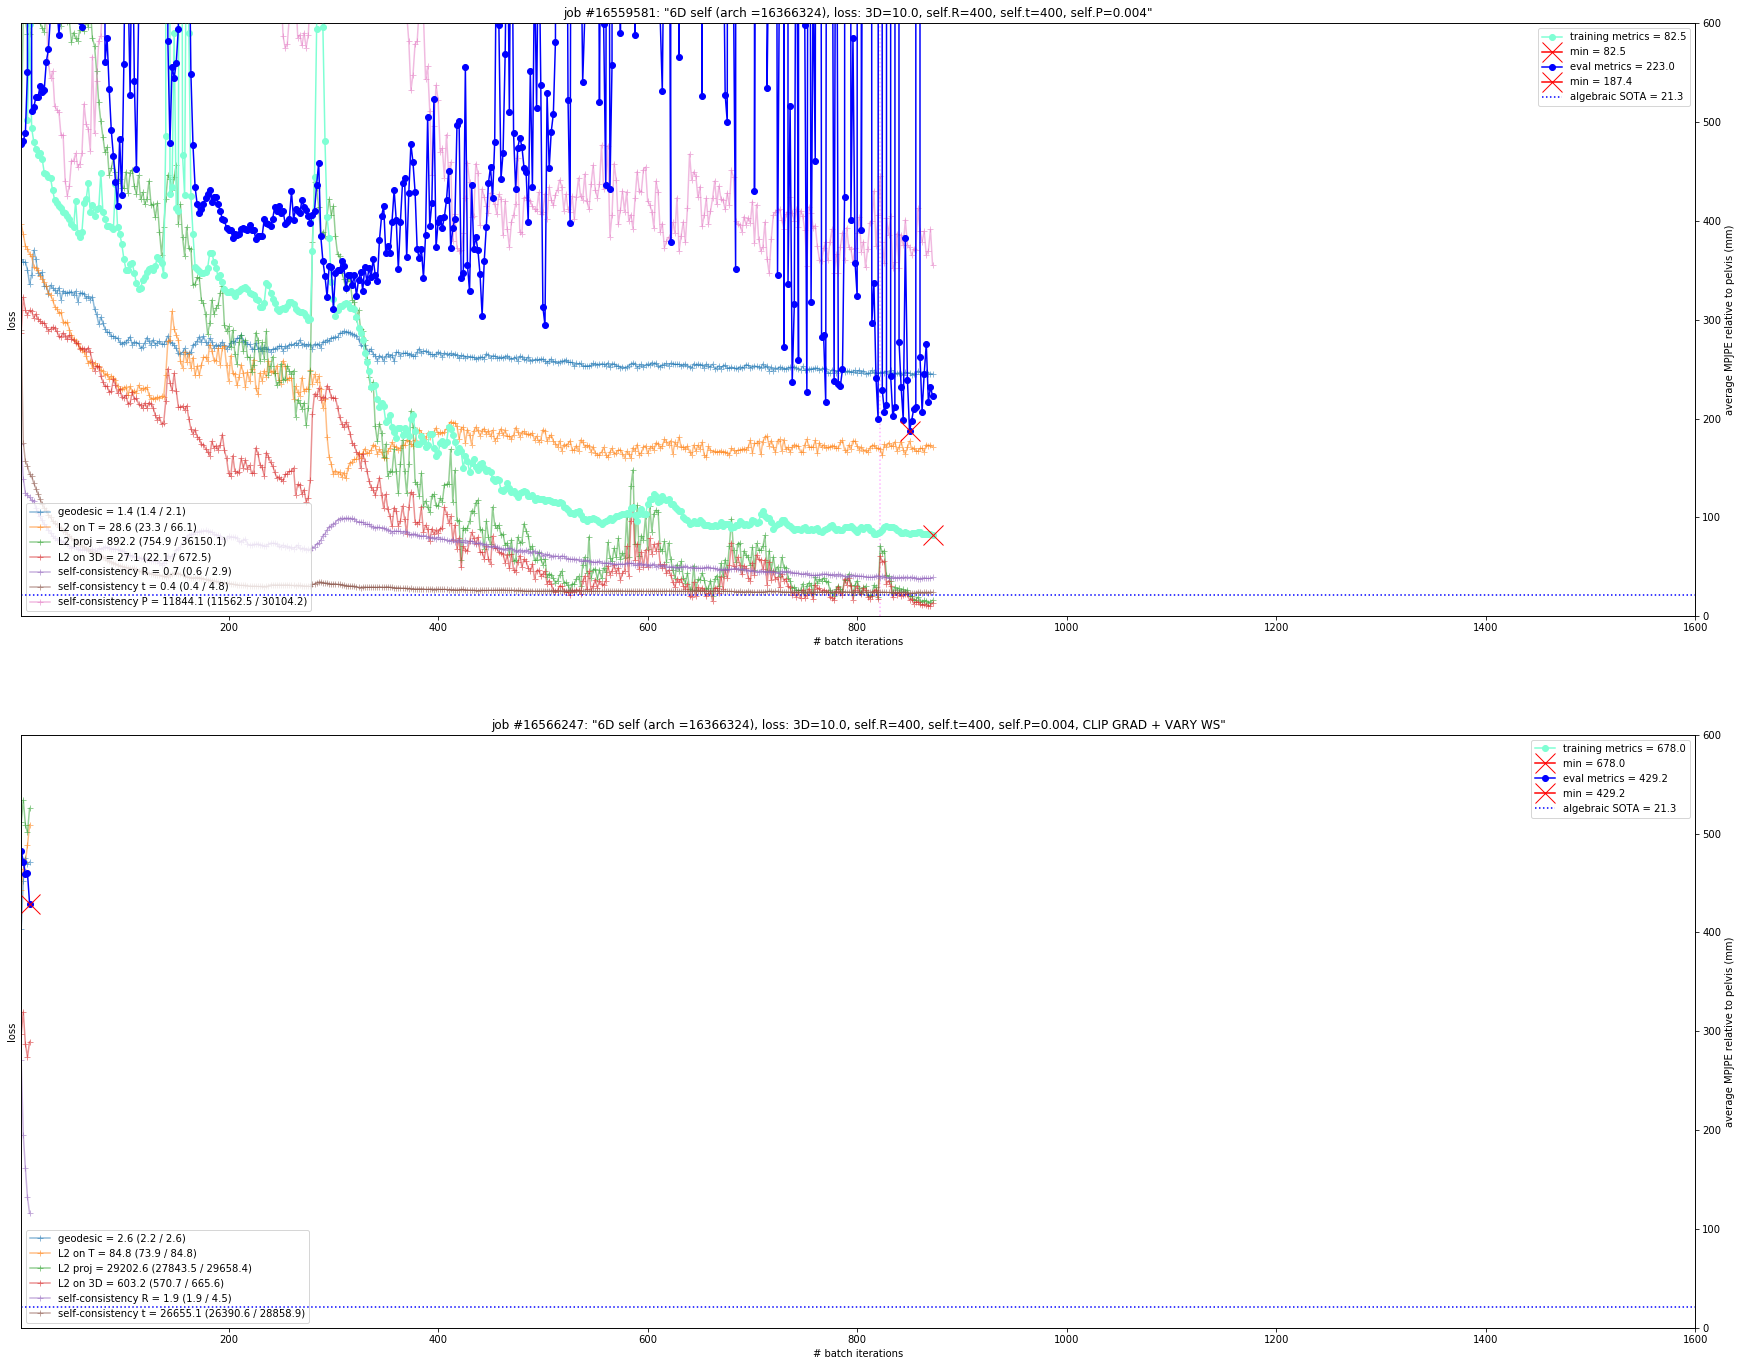

In [148]:
jobs = list(zip(*[
    #('15854643', 'wow'),  #  0c4ebaf24b30a8d33e78a289fbafc2ea4924e169
    #another baseline ('15926479', 'norm Fro, supervision: 3D, R | t'),
    #('16309282', '~ 15854643'),  # 3D jiggly at end

    #('16366324', 'Rodri arch search: 512 x 6/2/2, loss: geo=10, t=5, 3D=1.0, self.R=1, self.t=1'),  # not too many ws (learn fast) and not too low (can learn)
    #('16371540', 'Rodri arch search: 512 x 8/1/1, loss: '),
    #('16382002', 'Rodri arch search: 512 x 6/2/2, loss: '),
    #('16400494', 'Rodri arch search: 256 x 6/2/2. Loss += self.c'),    
    
    #('16439834', '6D supervised (arch =16366324), loss: geo=100, t=2, 3D=5.0, self.R=0.1, self.t=0.1, self.P=0.001'),  # R | t are weighted little => do not learn as fast as 16366324
    #('16444753', 'Rodri supervised (arch =16366324), loss: geo=100, t=2, 3D=5.0, self.R=0.1, self.t=0.1, self.P=0.001'),

    #('16433256', '6D self (arch =16366324), loss: 3D=5.0, self.R=50, self.t=20, self.P=0.05'),
    #('16545028', '6D self (arch =16366324), loss: 3D=5.0, self.R=400, self.t=400, self.P=0.003'),
    ('16559581', '6D self (arch =16366324), loss: 3D=10.0, self.R=400, self.t=400, self.P=0.004'),
    ('16566247', '6D self (arch =16366324), loss: 3D=10.0, self.R=400, self.t=400, self.P=0.004, CLIP GRAD + VARY WS')
    #('16424657', 'Rodri self (arch =16366324), loss: 3D=3.0, self.R=50, self.t=20, self.P=0.05'),
    
    # loss weights are the most IMPORTANT THING: ablated loss is MARVELLOUS
    # self.R|t is a proxy for a good R|t
    # possible strategy: once below threshold of self.c, raise weights of 2|3D losses (lower when not self.c)
    # 6D >> Rodr (when loss ws are balanced)
    # =>
    # 1) overfit big dataset
    #('16441762', '=16439834 (big dataset)')
    
    # 2) need to solve problem of worsening geo | t ...
    # weight self.R|t ~ self.P => at start I'm consistent, then I predict P ..., 3D are weighted x10 self.P
    # 3) try solution of 2) on big dataset
]))

plot_jobs(jobs[0], jobs[1], metrics_ylim=[0, 6e2])